In [97]:
import sys,os,json
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import mlflow

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Flatten, InputLayer, Dense, Dropout, BatchNormalization,Conv2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.metrics import Accuracy,Recall,PrecisionAtRecall,RecallAtPrecision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import warnings
warnings.filterwarnings('ignore')

seed = 42
tf.random.set_seed(seed=seed)

file_path = '/Users/paulosgidyelew/Desktop/Capstone_Project/data/kaggle_data/' 
train_path = '/Users/paulosgidyelew/Desktop/Capstone_Project/data/kaggle_data/train_images'

In [2]:
data = pd.read_csv(file_path+'train.csv')

with open(file_path+'label_num_to_disease_map.json') as file:
    str_labels = json.load(file)
    str_labels = {int(k):v for k,v in str_labels.items()}
data['label_name'] = data.label.map(str_labels)

In [3]:
data = data.reindex(columns=['image_id','label_name','label'])
data.head()

,image_id,label_name,label
0,1000015157.jpg,Cassava Bacterial Blight (CBB),0
1,1000201771.jpg,Cassava Mosaic Disease (CMD),3
2,100042118.jpg,Cassava Brown Streak Disease (CBSD),1
3,1000723321.jpg,Cassava Brown Streak Disease (CBSD),1
4,1000812911.jpg,Cassava Mosaic Disease (CMD),3


In [4]:
data.label_name.unique()

array(['Cassava Bacterial Blight (CBB)', 'Cassava Mosaic Disease (CMD)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Healthy'], dtype=object)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    21397 non-null  object
 1   label_name  21397 non-null  object
 2   label       21397 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 501.6+ KB


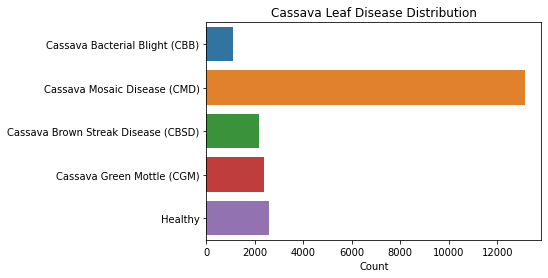

In [6]:
sns.countplot(data=data,y=data.label_name)
plt.title('Cassava Leaf Disease Distribution')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

In [7]:
image_data_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range = 45,
                                            width_shift_range = 0.2,
                                            height_shift_range = 0.2,
                                            shear_range = 0.2,
                                            zoom_range = 0.2,
                                            horizontal_flip = True,
                                            vertical_flip = True,
                                            validation_split=0.2,
                                            fill_mode = 'nearest')

train_set = image_data_generator.flow_from_dataframe(data,
                         directory = train_path,
                         seed=seed,
                         target_size=(380,380),
                         subset='training',
                         x_col = 'image_id',
                         y_col = 'label_name',
                         class_mode = 'categorical',
                         shuffle = True,
                         batch_size = 32)

val_set = image_data_generator.flow_from_dataframe(data,
                         directory = train_path,
                         seed=seed,
                         target_size=(380,380),
                         subset='validation',
                         x_col = 'image_id',
                         y_col = 'label_name',
                         class_mode = 'categorical',
                         shuffle = False,
                         batch_size = 32)

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


## Trainining the model and tracking with MLFlow

In [8]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

In [9]:
print("Active run_id: {}".format(run.info.run_id))

Active run_id: b98d91af170144e1884e29790c88451d


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
check_point_file_path = 'model.h5'
model_check_point = tf.keras.callbacks.ModelCheckpoint(check_point_file_path,
                                        verbose=1,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='auto',
                                        save_best_only=True
                                        )

In [11]:
TFL_HUB_HANDLE = "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1"

model = Sequential()
model.add(InputLayer(input_shape = (380,380,3)))
model.add(hub.KerasLayer(TFL_HUB_HANDLE, trainable=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,'softmax'))

2021-11-30 18:09:45.361545: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy', 
            metrics=[Accuracy(), Recall(), PrecisionAtRecall(recall=0.8)])
            
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1792)              17673816  
                                                                 
 dense (Dense)               (None, 64)                114752    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 17,790,813
Trainable params: 116,997
Non-t

In [41]:
history = model.fit(train_set, epochs=2, verbose=1, callbacks=[model_check_point], validation_data=val_set)

Epoch 1/2
535/535 [==============================] - ETA: 0s - loss: 0.9964 - accuracy: 1.1684e-05 - recall: 0.4733 - precision_at_recall: 0.4476
Epoch 00001: val_loss improved from inf to 0.81922, saving model to model.h5
535/535 [==============================] - 3943s 7s/step - loss: 0.9964 - accuracy: 1.1684e-05 - recall: 0.4733 - precision_at_recall: 0.4476 - val_loss: 0.8192 - val_accuracy: 0.0000e+00 - val_recall: 0.5155 - val_precision_at_recall: 0.6019
Epoch 2/2
535/535 [==============================] - ETA: 0s - loss: 0.8865 - accuracy: 2.3367e-05 - recall: 0.5246 - precision_at_recall: 0.5213
Epoch 00002: val_loss improved from 0.81922 to 0.77264, saving model to model.h5
535/535 [==============================] - 4112s 8s/step - loss: 0.8865 - accuracy: 2.3367e-05 - recall: 0.5246 - precision_at_recall: 0.5213 - val_loss: 0.7726 - val_accuracy: 0.0000e+00 - val_recall: 0.5321 - val_precision_at_recall: 0.6268


In [107]:
path = '/Users/paulosgidyelew/Desktop/Cassava_Disease_Classifier/cassava-classification-capstone/images/'

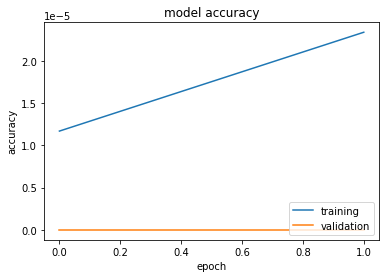

In [145]:
from tensorflow.keras.utils import plot_model

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.savefig(path+'acc.png')
plt.show()

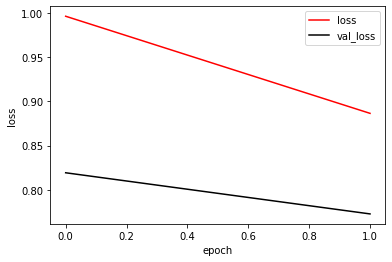

In [144]:
plt.plot(history.history['loss'],color='r')
plt.plot(history.history['val_loss'],color='k')
plt.legend(['loss','val_loss'],loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(path+f"loss.png")      
plt.show()

In [47]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "model_summary": [f'{layer.name}: {str(layer.trainable)}' for layer in model.layers],
      "loss function": model.loss,
      "model": model.name,
      "input_shape": model.input_shape[1:],
      "output_shape": model.output_shape,
      "epoch": history.epoch
  }

In [101]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", True)
mlflow.set_experiment('model_1')
#logging metrics
mlflow.log_metric("F2 score", history.history['precision_at_recall'][-1])
mlflow.log_metric("F2 score", history.history['val_precision_at_recall'][-1])
mlflow.log_metric("recall", history.history['recall'][-1])
mlflow.log_metric("val_recall", history.history['val_recall'][-1])
mlflow.log_metric("loss",history.history['loss'][-1])
mlflow.log_metric("val_loss",history.history['val_loss'][-1])
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

In [102]:
mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'F2 score': 0.626781165599823,
 'accuracy': 0.5245940089225769,
 'loss': 0.88648521900177,
 'recall': 0.5245940089225769,
 'val_accuracy': 0.5321336984634399,
 'val_loss': 0.7726395130157471}, params={'epoch': '[0, 1]',
 'input shape': '(380, 380, 3)',
 'loss function': 'categorical_crossentropy',
 'model': 'sequential',
 'model_summary': "['keras_layer: False', 'dense: True', 'dropout: True', "
                  "'dense_1: True', 'dropout_1: True', 'dense_2: True']",
 'output shape': '(None, 5)'}, tags={'mlflow.source.name': 'ipykernel_launcher',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'paulosgidyelew',
 'running_from_jupyter': 'True'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/35/b98d91af170144e1884e29790c88451d/artifacts', end_time=1638303232950, experiment_id='35', lifecycle_stage='active', run_id='b98d91af170144e1884e29790c88451d', run_uuid='b98d91af170144e1884e29790c88451d', start_time=1638292164027, status='FINISH

## Checking the experiments

while the next cell is running you will not be able to run other cells in the notebook

In [74]:
!mlflow ui

/Users/paulosgidyelew/Desktop/Cassava_Disease_Classifier/cassava-classification-capstone/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
[2021-11-30 21:14:28 +0100] [2190] [INFO] Starting gunicorn 20.1.0
[2021-11-30 21:14:28 +0100] [2190] [INFO] Listening at: http://127.0.0.1:5000 (2190)
[2021-11-30 21:14:28 +0100] [2190] [INFO] Using worker: sync
[2021-11-30 21:14:28 +0100] [2191] [INFO] Booting worker with pid: 2191
/Users/paulosgidyelew/Desktop/Cassava_Disease_Classifier/cassava-classification-capstone/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
^C
[2021-11-30 21:18:53 +0100] [2190] [INFO] Handling signal: int